# EPS Computing Survey Results

Let's have some fun analysing the EPS computing survey results!

## Getting started

First we need to import the nice Excel spreadsheet created by Google...

In [489]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

sns.set_context("poster")
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

results = pd.read_excel('Computing_Survey.xlsx')


Now we should give each of the questions slightly snappier names.

In [552]:
column_names = {
               'Timestamp' : 'timestamp',
               'What is your position in EPS?': 'position',
               'What is your discipline?': 'discipline',
               'Which operating system(s) do you normally use for your work?': 'os',
               'Which best describes how often you currently program?': 'prog_freq',
               'Which, if any, of the following programming languages do you often use?': 'langs',
               'Which, if any, of the following types of data files do you commonly deal with?': 'data_files',
               'How familiar are you with Git/version control?': 'git',
               'What do you often use for writing?': 'writing',
               'What computers do you regularly work on, either remotely or in person?':'comps',
               'Where do you keep your data?':'data_where',
               'Would you be interested in attending a workshop on computing skills?':'workshop',
               'What would you be most interested in learning about at such a workshop?':'learn',
               'Are there any issues you would like to raise about IT in the department/university?':'it_issues'
               }

results.rename(columns=column_names, inplace=True)
results.timestamp = pd.to_datetime(results.timestamp).dt.hour

# Now let's print the raw results of the survey
results


,timestamp,position,discipline,os,prog_freq,langs,data_files,git,writing,comps,data_where,workshop,"If so, which time(s) of year would work for you?",learn,it_issues
0,0,Grad Student,Planetary Science,[Mac OS X],I program a few times a year,"[Matlab, IDL]","[CSV/Plain text, Excel/Spreadsheet]",I have heard of Git/version control but never ...,"[LaTeX, Pages]",[My personal computer/computer which only I use],[My personal storage/storage which only I use],Yes,Shortly before the Fall Semester,NaN,NaN
1,0,Research Scientist,Ocean/Atmosphere/Climate Science,[Linux],I program almost every day,"[Fortran, Matlab, Ferret, Shell scripts]","[NetCDF, CSV/Plain text, Excel/Spreadsheet, ...",I have heard of Git/version control but never ...,[LaTeX],[My personal computer/computer which only I us...,"[My personal storage/storage which only I use,...",Yes,"Shortly before the Fall Semester, Shortly befo...",in-depth Python,NaN
2,0,Grad Student,Ocean/Atmosphere/Climate Science,"[Mac OS X, Linux]",I program almost every day,"[Python, Shell scripts]",[NetCDF],I have used or am using Git/version control,"[LaTeX, Other plain text]",[My personal computer/computer which only I us...,"[Blaustein/Blaustein2, Datascope]",Yes,"Shortly before the Fall Semester, Shortly befo...",NaN,NaN
3,0,Post-doc,Ocean/Atmosphere/Climate Science,[Mac OS X],I program almost every day,"[Fortran, Matlab, IDL, Ferret, Shell scripts]","[NetCDF, CSV/Plain text, Binary]",I have never heard of Git/version control,[LaTeX],[My personal computer/computer which only I us...,[Blaustein/Blaustein2],Yes,Shortly before the Fall Semester,Shell,NaN
4,0,Grad Student,Ocean/Atmosphere/Climate Science,[Linux],I program almost every day,"[Fortran, Python, Matlab, Shell scripts]","[NetCDF, Binary, Database]",I have used or am using Git/version control,"[OpenOffice/LibreOffice, LaTeX]",[My personal computer/computer which only I us...,"[MARCC, Other shared storage within JHU]",Yes,Shortly before the Spring Semester,Automation and Make - Data Analysis and Visual...,NaN
5,0,Grad Student,Ocean/Atmosphere/Climate Science,"[Mac OS X, Linux]",I program almost every day,"[Python, Matlab]","[NetCDF, CSV/Plain text, Excel/Spreadsheet, ...",I have used or am using Git/version control,"[LaTeX, Other plain text]","[Blaustein/Blaustein2, Datascope, Other shar...","[Blaustein/Blaustein2, Datascope]",Yes,"Shortly before the Fall Semester, Shortly befo...",advanced git usage (specifically using git to ...,I would like to have a linux server with a mi...
6,0,Grad Student,Ocean/Atmosphere/Climate Science,"[Windows, Linux]",I program almost every day,"[Matlab, Shell scripts]","[NetCDF, Database]",I have never heard of Git/version control,[Word],[My personal computer/computer which only I us...,"[My personal storage/storage which only I use,...",Yes,Shortly before the Fall Semester,NaN,NaN
7,0,Grad Student,Ocean/Atmosphere/Climate Science,[Mac OS X],I program almost every day,[R],"[NetCDF, CSV/Plain text]",I have heard of Git/version control but never ...,[Word],[My personal computer/computer which only I us...,"[My personal storage/storage which only I use,...",Yes,Shortly before the Fall Semester,NaN,NaN
8,0,Grad Student,Planetary Science,[Mac OS X],I program almost every day,"[Python, Matlab, IDL]",[CSV/Plain text],I have heard of Git/version control but never ...,[LaTeX],[My personal computer/computer which only I use],[My personal storage/storage which only I use],Yes,Shortly before the Fall Semester,Data visualization,NaN
9,0,Grad Student,Ocean/Atmosphere/Climate Science,"[Mac OS X, Linux]",I program almost every day,[IDL],"[NetCDF, CSV/Plain text]",I have used or am using Git/version control,"[Word, LaTeX]",[My personal computer/computer which only I us...,"[Blaustein/Blaustein2, Storage outside of JHU]",Yes,Shortly before the Fall Semester,"Data storage, advanced programming skills",NaN


I'm going to make a couple of edits to deal with some outliers...

- Person 23 has set a unique discipline of Climate/Water/Satistics - that's close enough to Ocean/Atmosphere/Climate Science for me...
- Person 16 has chosen two disciplines... I'm going to set them to just 'Geochemistry' since there aren't many of them

In [491]:
results.replace(to_replace='Climate/Water/Satistics', value='Ocean/Atmosphere/Climate Science', inplace=True)
results.replace(to_replace='Ocean/Atmosphere/Climate Science, Geochemistry', value='Geochemistry', inplace=True)

We want the multiple-choice answers to be formatted into lists

In [492]:
for i in range(len(results)):
    results.set_value(i,'os',results.os[i].split(','))
    results.set_value(i,'langs',results.langs[i].split(','))
    results.set_value(i,'data_files',results.data_files[i].split(','))
    results.set_value(i,'writing',results.writing[i].split(','))
    results.set_value(i,'comps',results.comps[i].split(','))
    results.set_value(i,'data_where',results.data_where[i].split(','))

## Results by discipline

Now we want to calculate the frequency (relative to the total number of answers) of each answer within a question.

In [493]:
def group_answers(question,df):
    """Groups multiple choice answers together and calculates
    their relative frequencies
    """
    q_list = df[question].tolist()
    if question in ['os','langs','data_files','writing','comps','data_where']:
        q_flat = [item.strip() for sublist in q_list for item in sublist]
    else:
        q_flat=q_list
    q_df   = pd.Series(q_flat)
    freq = q_df.value_counts(normalize=True)
    return freq

Finally we can plot the results by discipline

In [509]:
def plot_results_by_discipline(question, title=''):
    """Plots a bar chart of relative frequency by discipline
    """
    freqs={}
    results_by_discipline={}
    for discipline in pd.Series(results.discipline.ravel()).unique():
        results_by_discipline[discipline] = results.loc[results['discipline'] == discipline]
        freqs[discipline] = group_answers(question, results_by_discipline[discipline])
    s = pd.concat(freqs, axis=1)
    
    f = plt.figure()
    s.plot(kind='barh', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel('frequency')
    
    plt.title(title)


Word is popular across all disciplines, but LaTeX just edges it out for Climate and Planetary people.

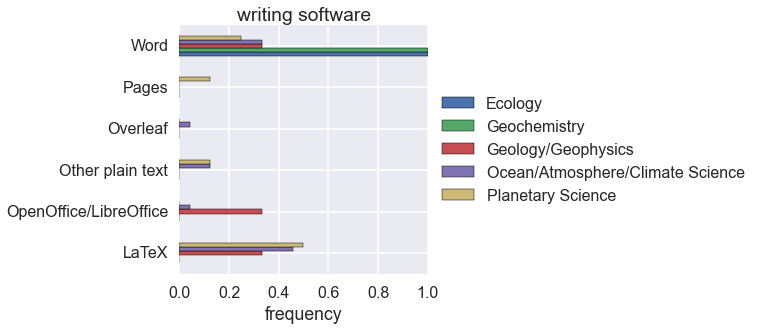

In [510]:
plot_results_by_discipline('writing', title='writing software' )

By far the most popular place to keep data is on your own personal computer, in fact for Ecology and Geochemistry it is the *only* place.

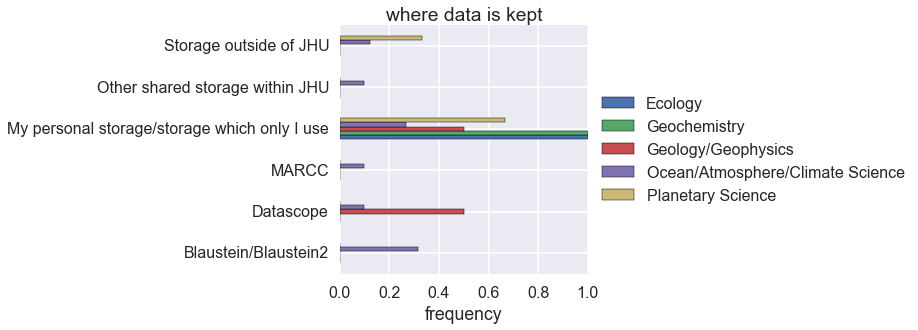

In [511]:
plot_results_by_discipline('data_where', title='where data is kept')

Nobody from Ecology, Geochemistry or Geology/Geophysics has heard of git.

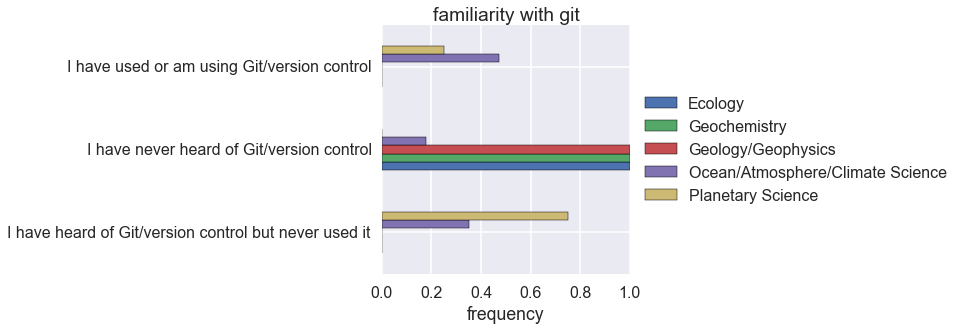

In [512]:
plot_results_by_discipline('git','familiarity with git')

## Long answer results

The best way to visualize these is with a word cloud!

In [513]:
a = results['learn'].tolist()
a = [i for i in a if str(i) != 'nan']
txt = ' '.join(a)

(-0.5, 399.5, 199.5, -0.5)

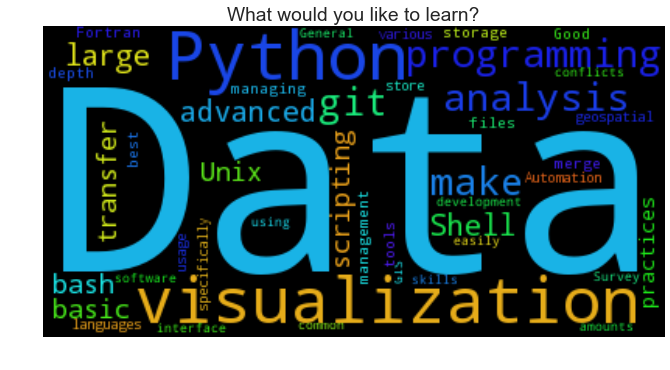

In [514]:
wordcloud = WordCloud().generate(txt)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.title('What would you like to learn?')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

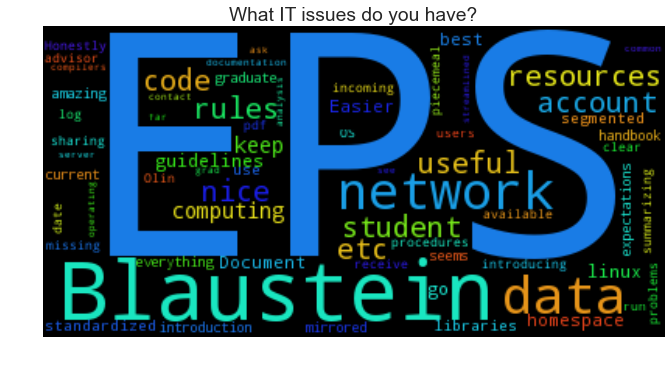

In [515]:
a = results['it_issues'].tolist()
a = [i for i in a if str(i) != 'nan']
txt = ' '.join(a)
wordcloud = WordCloud().generate(txt)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.title('What IT issues do you have?')
plt.axis("off")

## When do professors reply to their emails?

In [516]:
profs = results.loc[results['position'] == 'Faculty']
postdocs = results.loc[results['position'] == 'Post-doc']
scientists = results.loc[results['position'] == 'Research Scientist']
students = results.loc[results['position'] == 'Grad Student']

In [549]:
def plot_results_by_position(question, title=''):
    """Plots a bar chart of relative frequency by discipline
    """
    freqs={}
    results_by_position={}
    for position in pd.Series(results.position.ravel()).unique():
        results_by_position[position] = results.loc[results['position'] == position]
        freqs[position] = group_answers(question, results_by_position[position])
    s = pd.concat(freqs, axis=1)
    
    f = plt.figure()
    s.plot(kind='barh', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.xlabel('frequency')
    #plt.ylabel('hour')
    plt.title(title)

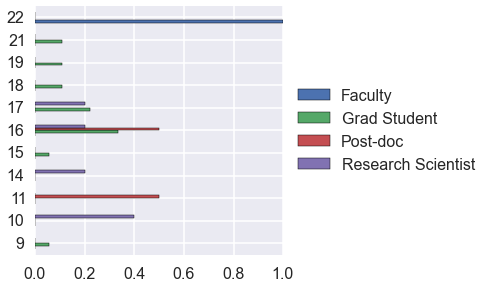

In [550]:
plot_results_by_position('timestamp')